# Purpose

This one demos output for `v0.3.2` that includes top subreddits (no Geo) AND German-relevant subreddits! Should be helpful to check for subreddit counterparts.

Use this notebook to present the outputs for the final output (or close to it). 

We need this notebook to show some clear examples on how to use the data and where/how we can use it.

# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [116]:
from datetime import datetime
import logging
from pprint import pprint

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow

import omegaconf
from omegaconf import OmegaConf
from subclu.utils.hydra_config_loader import LoadHydraConfig

import subclu
from subclu.data.data_loaders import LoadSubreddits, LoadPosts
from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)

from subclu.utils.mlflow_logger import MlflowLogger
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)

# ---
from tqdm.auto import tqdm
from subclu.data.counterpart_loaders import (
    LoadCounterpartSeeds,
    combine_reshaped_seeds
)
from subclu.data.prepare_subreddit_clusters_for_qa import (
    reshape_for_distance_qa
)


print_lib_versions([np, pd, plotly, sns, subclu])

python		v 3.7.10
===
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.3.2


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Load configs

Use Hydra configs to make it easier to replicate the run.

Copy the config to the model folder so it's easier to trace it back

In [141]:
config_clustering_v032a = LoadHydraConfig(
    config_name='cluster_output',
    config_path="../config",
    overrides=[
        f"data_text_and_metadata=top_subreddits_2021_07_16",
        f"data_embeddings_to_cluster=top_subs-2021_07_16-use_multi_lower_case_false_00",
        f"data_cluster_outputs=top_subreddits_v0.3.2a",
    ],
)
config_seeds = LoadHydraConfig(
    config_name='seed_counterparts_germany_2021-08-17',
    config_path="../config/data_subreddit_counterparts",
)

# pprint(config_clustering_v032a.config_dict, indent=2)
pprint(config_seeds.config_dict)

{'bucket_name': 'i18n-subreddit-clustering',
 'dataset_name': 'German subreddit seeds for counterparts',
 'f_seeds1': 'Criteria for default subs - [OLD]default '
             'subs-2021-08-13_15-17.csv',
 'f_seeds2': 'Criteria for default subs - [final] '
             'autosub+counterpart-2021-08-18.csv',
 'f_skiprows1': 3,
 'f_skiprows2': 1,
 'folder_data_prefix': 'data/subreddit_counterparts'}


In [142]:
# Extract CLUSTERING keys into easier to call
d_embeddings = config_clustering_v032a.config_dict['data_embeddings_to_cluster']
d_conf_meta = config_clustering_v032a.config_dict['data_text_and_metadata']
d_clusters = config_clustering_v032a.config_dict['data_cluster_outputs']

# embedding data
run_uuid = d_embeddings['run_uuid']

f_embeddings_sub_level = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc']
f_embeddings_post_level = d_embeddings['df_post_level_agg_c_post_comments_sub_desc']

f_sub_distance_c = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc_similarity']
f_sub_dist_pair_c = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair']

l_ix_sub = d_embeddings['l_ix_sub']  # 'subreddit_id',  b/c of dask's multi-index, I'm only using name
l_ix_post = d_embeddings['l_ix_post']

# cluster output data
bucket_and_folder_prefix = f"gs://{d_clusters['bucket_name']}/{d_clusters['folder_model_outputs']}"
f_subs_c_cluster_labels = d_clusters['f_subs_agg_c_cluster_labels']
f_subs_c_similarity_pair = d_clusters['f_subs_agg_c_similarity_pair']
col_best_clusters_a = d_clusters['col_best_clusters_a']
# NEW cluster-QA file (2021-08-19)
f_cluster_summary_qa = d_clusters['f_cluster_summary_qa']

In [143]:
# Extract seed configs
gcs_seeds_path = (
    f"gs://{config_seeds.config_dict['bucket_name']}/"
    f"{config_seeds.config_dict['folder_data_prefix']}/"
    f"{config_seeds.config_dict['f_seeds1']}"
)
gcs_seeds_path

'gs://i18n-subreddit-clustering/data/subreddit_counterparts/Criteria for default subs - [OLD]default subs-2021-08-13_15-17.csv'

# Load German geo-relevant & Ambassador subreddits

Need to export them from BigQuery first (sigh).

Use them to create flags to make it easier to find counterparts.

In [6]:
config_geo_relevant = LoadHydraConfig(
    config_name='geo_relevant_subs_2021-08-18',
    config_path="../config/data_geo_relevant_subreddits",
)
config_ambassador = LoadHydraConfig(
    config_name='de_ambassador_subs_2021-08-18',
    config_path="../config/data_ambassador_subreddits",
)

In [7]:
%%time

df_geo = pd.read_parquet(
    f"gs://{config_geo_relevant.config_dict['bucket_name']}/"
    f"{config_geo_relevant.config_dict['folder_data_prefix']}/"
)
print(df_geo.shape)

(8115, 6)
CPU times: user 256 ms, sys: 30.4 ms, total: 287 ms
Wall time: 1.3 s


In [8]:
%%time

df_ambassador = pd.read_parquet(
    f"gs://{config_ambassador.config_dict['bucket_name']}/"
    f"{config_ambassador.config_dict['folder_data_prefix']}/"
)
print(df_ambassador.shape)

(171, 3)
CPU times: user 9.07 ms, sys: 10.2 ms, total: 19.2 ms
Wall time: 630 ms


# Load Seeds

This class takes care of renaming and cleaning up a lot of columns

### Original format (wide, counterparts are in columns)

No need to load in this shape except for QA... see section below that gets us the shape we need.

In [9]:
# %%time
# df_sub_seeds_old = LoadCounterpartSeeds(
#     bucket_name=config_seeds.config_dict['bucket_name'],
#     folder_path=config_seeds.config_dict['folder_data_prefix'],
#     file_name=config_seeds.config_dict['f_seeds1'],
#     skiprows=config_seeds.config_dict['f_skiprows1'],
#     columns='core_columns',
#     df_format='pandas_csv',
# ).read_and_transform()
# print(df_sub_seeds.shape)

In [10]:
# %%time
# df_sub_seeds_new = LoadCounterpartSeeds(
#     bucket_name=config_seeds.config_dict['bucket_name'],
#     folder_path=config_seeds.config_dict['folder_data_prefix'],
#     file_name=config_seeds.config_dict['f_seeds2'],
#     skiprows=config_seeds.config_dict['f_skiprows2'],
#     columns='core_columns',
#     df_format='pandas_csv',
# ).read_and_transform()
# print(df_sub_seeds_new.shape)

In [11]:
# counts_describe(df_sub_seeds_old)

In [12]:
# counts_describe(df_sub_seeds_new)

In [13]:
# df_sub_seeds_new.head()

In [14]:
# df_sub_seeds_old.head()

In [15]:
# del df_sub_seeds_new, df_sub_seeds_old

### Load reshaped format (long - each counterpart is a row)

In [17]:
df_sub_seeds_reshape_old = LoadCounterpartSeeds(
    bucket_name=config_seeds.config_dict['bucket_name'],
    folder_path=config_seeds.config_dict['folder_data_prefix'],
    file_name=config_seeds.config_dict['f_seeds1'],
    skiprows=config_seeds.config_dict['f_skiprows1'],
    columns='core_columns',
    df_format='pandas_csv',
).read_and_reshape_to_rows()
print(df_sub_seeds_reshape_old.shape)

15:22:31 | INFO | "Reading raw data..."
15:22:31 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/data/subreddit_counterparts"


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:32 | INFO | "  Applying transformations..."


(80, 9)


In [18]:
df_sub_seeds_reshape_new = LoadCounterpartSeeds(
    bucket_name=config_seeds.config_dict['bucket_name'],
    folder_path=config_seeds.config_dict['folder_data_prefix'],
    file_name=config_seeds.config_dict['f_seeds2'],
    skiprows=config_seeds.config_dict['f_skiprows2'],
    columns='core_columns',
    df_format='pandas_csv',
).read_and_reshape_to_rows()
print(df_sub_seeds_reshape_new.shape)

15:22:32 | INFO | "Reading raw data..."
15:22:32 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/data/subreddit_counterparts"


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:33 | INFO | "  Applying transformations..."


(74, 13)


In [19]:
counts_describe(df_sub_seeds_reshape_old)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_name,object,80,62,77.50%,0,0.00%
manual_counterpart,object,71,2,2.82%,9,11.25%
counterpart_name,object,71,69,97.18%,9,11.25%
counterpart_priority,float64,57,5,8.77%,23,28.75%
topic_seed,object,79,22,27.85%,1,1.25%
pod,object,47,5,10.64%,33,41.25%
german,object,79,2,2.53%,1,1.25%
ambassador_sub,object,79,3,3.80%,1,1.25%
type_of_content_seed,object,79,11,13.92%,1,1.25%


In [20]:
counts_describe(df_sub_seeds_reshape_new)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_name,object,74,40,54.05%,0,0.00%
manual_counterpart,object,73,2,2.74%,1,1.35%
counterpart_name,object,73,71,97.26%,1,1.35%
counterpart_priority,float64,47,4,8.51%,27,36.49%
topic_seed,object,74,15,20.27%,0,0.00%
pod,object,53,5,9.43%,21,28.38%
german,object,62,2,3.23%,12,16.22%
ambassador_sub,object,74,2,2.70%,0,0.00%
type_of_content_seed,object,74,9,12.16%,0,0.00%
counterpart_3,object,30,15,50.00%,44,59.46%


In [21]:
# df_sub_seeds_reshape_new.head()

In [22]:
# df_sub_seeds_reshape_new.tail()

In [23]:
# df_sub_seeds_reshape_old.head()

In [24]:
df_sub_seeds_reshape_old.tail()

,subreddit_name,manual_counterpart,counterpart_name,counterpart_priority,topic_seed,pod,german,ambassador_sub,type_of_content_seed
75,germusic,NaN,NaN,NaN,music,NaN,NaN,NaN,NaN
76,rocketbeans,NaN,NaN,3.0,tv,NaN,yes,no,video
77,smalllebowsky,NaN,NaN,2.0,art,NaN,yes,no,photos
78,de_events,NaN,NaN,NaN,culture/society,culture + entertainment,yes,yes,links and text
79,mediathek,NaN,NaN,NaN,tv,culture + entertainment,yes,yes,links and text


## Combine reshaped seeds into single df

In [25]:
df_sub_seeds_combined = combine_reshaped_seeds(
    df_new=df_sub_seeds_reshape_new,
    df_old=df_sub_seeds_reshape_old,
    cols_combine=None,
)

15:22:46 | INFO | "(109, 6) <- Shape before removing dupes"
15:22:46 | INFO | "(108, 6) <- Shape AFTER removing dupes"


In [26]:
df_sub_seeds_combined.head(15)

,subreddit_name,manual_counterpart,counterpart_name,ambassador_sub,type_of_content_seed,counterpart_priority
25,binichdasarschloch,counterpart_1,amitheasshole,yes,text,5.0
26,binichdasarschloch,counterpart_2,assholetax,yes,text,5.0
53,dachgaming,counterpart_1,gaming,yes,all,5.0
54,dachgaming,counterpart_2,games,yes,all,5.0
73,de,NaN,NaN,no,links and text,5.0
2,finanzen,counterpart_1,finance,no,text,5.0
3,finanzen,counterpart_2,financialindependence,no,text,5.0
4,fragreddit,counterpart_1,askreddit,no,text,5.0
5,fragreddit,counterpart_2,ask,no,text,5.0
59,fussball,counterpart_1,soccer,yes,"links, text, screenshots",5.0


In [27]:
# df_sub_seeds_combined.tail(15)

In [28]:
# delete the raw dfs to clean up name space
del df_sub_seeds_reshape_new, df_sub_seeds_reshape_old

# Load Distances & Clusters (cluster IDs)

These should be the same files that feed the bigquery tables:
- `reddit-employee-datasets.david_bermejo.subclu_subreddit_distance_v0032_c_posts_and_comments_and_meta`
- `reddit-employee-datasets.david_bermejo.subclu_subreddit_cluster_labels_v032_a`


In [29]:
print(bucket_and_folder_prefix)
print(f_subs_c_cluster_labels)
print(f_subs_c_similarity_pair)
print(col_best_clusters_a)

gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45
df_subs_only-meta_and_multiple_clustering_algos-2021-08-13_022453-3767_by_58.parquet
df_sub_level_agg_c_similarity_pair-2021-08-13_021828-14186522_by_18.parquet
cluster_id_agg_ward_cosine_200


In [137]:
# !gsutil ls -r $bucket_and_folder_prefix
!gsutil ls $bucket_and_folder_prefix

gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_posts_meta_and_svd-1651709_by_72.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_sub_level_agg_c_similarity_pair-2021-08-13_003946-14186522_by_18.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_sub_level_agg_c_similarity_pair-2021-08-13_021828-14186522_by_18.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_subs_meta_and_svd-3767_by_88.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_subs_only-cluster_level_pivot_for_qa-2021-08-19_0623-200_by_7.csv
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_subs_only-meta_and_clustering_for_qa-2021-08-18_2339-3768_by_37.csv
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_subs_only-meta_and_multiple_clustering_algos-2021-08-13_022453-3767_by_58.p

In [31]:
%%time
df_subs_cluster = pd.read_parquet(f"{bucket_and_folder_prefix}/{f_subs_c_cluster_labels}")

print(df_subs_cluster.shape)

(3767, 58)
CPU times: user 88.5 ms, sys: 54.2 ms, total: 143 ms
Wall time: 825 ms


In [32]:
%%time
# this one will take a while (over 15 seconds) because it's over 14 million rows...
df_subs_distance = pd.read_parquet(f"{bucket_and_folder_prefix}/{f_subs_c_similarity_pair}")

print(df_subs_distance.shape)

(14186522, 18)
CPU times: user 13.9 s, sys: 2.4 s, total: 16.3 s
Wall time: 8.86 s


In [33]:
df_subs_cluster[[c for c in df_subs_cluster.columns if 'description' not in c]].iloc[:6, :14]

,subreddit_name,cluster_id_agg_ward_cosine_200,subreddit_title,rating,topic,over_18,subreddit_language,primary_post_language,primary_post_language_percent,primary_post_type,primary_post_type_percent,posts_for_modeling_count,post_median_word_count,primary_post_language_in_use_multilingual
0,natureismetal,0,Nature is Metal,pg13,None,f,en,English,0.918333,image,0.566667,1200,9.0,True
1,ape,0,ape,not_shown_in_theaters,None,f,en,English,0.569423,image,0.329173,641,5.0,True
2,flyfishing,0,flyfishing,g,None,f,en,English,0.940833,image,0.495000,1200,9.0,True
3,birding,0,a place for birders to be,pg13,None,f,en,English,0.917500,image,0.653333,1200,8.0,True
4,bassfishing,0,Bass Fishing at its Finest,pg,None,f,en,English,0.920833,image,0.437500,1200,12.0,True
5,beach,0,Welcome to Beach Reddit!,pg,None,f,en,English,0.715789,link,0.463158,475,6.0,True


In [34]:
df_subs_distance.iloc[:6, :14]

,cosine_distance,subreddit_name_a,subreddit_name_b,rating_b,topic_b,primary_post_language_b,primary_post_language_percent_b,post_median_word_count_b,post_median_word_count_a,rating_a,topic_a,primary_post_language_a,primary_post_language_percent_a,subreddit_id_a
0,0.719657,1071,tamamahbapengelli,None,None,Turkish,0.677419,4.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
1,0.708699,1071,nonakanal,None,None,German,0.712589,6.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
2,0.706756,1071,okemakkermaloot,None,None,Dutch,0.358974,3.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
3,0.706363,1071,kudurdum,None,None,Turkish,0.544170,7.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
4,0.698231,1071,okbrudimongo,r,Internet Culture and Memes,German,0.651042,4.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q
5,0.695058,1071,playboicartihentai,None,None,English,0.592391,5.0,9.0,None,None,Turkish,0.845133,t5_4ppr4q


## Load new cluster summary

Use it to filter out or down-rank subs that are in NSFW clusters. Doesn't make sense to waste time ranking these b/c we won't use them yet.

In [90]:
%%time
df_cluster_level_qa = pd.read_csv(
    f"{bucket_and_folder_prefix}/{f_cluster_summary_qa}",
    skiprows=d_clusters['f_skiprows_cluster_summary_qa'],   
)

print(df_cluster_level_qa.shape)

(200, 15)
CPU times: user 10.7 ms, sys: 7.79 ms, total: 18.5 ms
Wall time: 174 ms


In [91]:
df_cluster_level_qa = (
    df_cluster_level_qa
    .rename(columns={'cluster ID\n(ward cosine 200)': col_best_clusters_a})
    .rename(
        columns={c: (c
                     .lower().replace(' ', '_')
                     .replace('.', '')
                     .replace('\n', '_')
                     .replace('(', '')
                     .replace(')', '')
                    ) for c in df_cluster_level_qa.columns}
    )
)

df_cluster_level_qa = df_cluster_level_qa[[c for c in df_cluster_level_qa.columns if not c.endswith('cumul_sum')]]

### Create new column to set priority to label at cluster-level

Main ideas: 
- move NSFW clusters to the bottom
- keep clusters that have similar/shared topics at the top
- keep clusters with a lot of German subs at the top

In [92]:
# sort col ascending=False to see German subreddits first
df_cluster_level_qa['cluster_has_german_subs_and_mostly_sfw'] = np.where(
    (
        (df_cluster_level_qa['qa_topic_tier_1'].isin(['Mature Themes and Adult Content'])) |
        (df_cluster_level_qa['german_subs_in_cluster_count'] < 1)
    ),
    'no',
    'yes'
)

In [97]:
df_cluster_level_qa = (
    df_cluster_level_qa
    .sort_values(
        by=['cluster_has_german_subs_and_mostly_sfw', 'primary_topics_in_cluster', ],
        ascending=[False, False, ],
    )
)
# df_cluster_level_qa.head()

## Load subreddit-level QA df
It already contains a lot of URLs and aggregates that we don't need to recreate

In [144]:
%%time
df_sub_cluster_qa = pd.read_csv(
    f"{bucket_and_folder_prefix}/{d_clusters['f_sub_level_cluster_qa_raw']}",
    skiprows=d_clusters['f_skiprows_sub_level_cluster_qa_raw'],   
)

print(df_sub_cluster_qa.shape)

(3768, 37)
CPU times: user 66 ms, sys: 3.46 ms, total: 69.4 ms
Wall time: 297 ms


In [148]:
# counts_describe(df_sub_cluster_qa)

In [156]:
# df_sub_cluster_qa[[c for c in df_sub_cluster_qa.columns if not c.endswith('_description')]].head()

### add newly created cluster-level column to help sort final output

In [154]:
df_sub_cluster_qa = df_sub_cluster_qa.merge(
    df_cluster_level_qa[[col_best_clusters_a, 'cluster_has_german_subs_and_mostly_sfw']],
    how='left',
    on=col_best_clusters_a
)
df_sub_cluster_qa.shape

(3768, 38)

In [155]:
df_sub_cluster_qa[[c for c in df_sub_cluster_qa.columns if not c.endswith('_description')]].head()

,cluster_id_agg_ward_cosine_200,german_subs_in_cluster,primary_topics_in_cluster,subreddit_name,subreddit_id,subreddit_title,subreddit_url,subreddit_url_with_google_translate,german_or_ambassador_sub,geo_country_code,ambassador_sub,over_18,rating,topic,rating_version,topic_version,subreddit_language,primary_post_language,primary_post_language_percent,English_posts_percent,German_posts_percent,primary_post_type,primary_post_type_percent,posts_for_modeling_count,post_median_word_count,subscribers,users_l28,posts_l28,comments_l28,image_post_type_percent,text_post_type_percent,link_post_type_percent,mlflow_aggregation_run_uuid,manual_topic_and_rating,pt,users_l28_for_cluster,cluster_has_german_subs_and_mostly_sfw
0,79,0,"world news, over18_nsfw, podcasts and streamers, uncategorized",conspiracy,t5_2qh4r,conspiracy,https://www.reddit.com/r/conspiracy,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/conspiracy,no,NaN,no,f,r,NaN,v1,NaN,en,English,0.959167,0.959167,0.001667,image,0.454167,1200,19.0,1539186,1526551,14329,425993,0.454167,0.225833,0.280000,99158c385c5442b1bf5ff96fc44af7da,uncategorized,2021-07-16,2555559,no
1,79,0,"world news, over18_nsfw, podcasts and streamers, uncategorized",worldnewsvideo,t5_31m0v,r/WorldNewsVideo: An Accurate Representation of the World,https://www.reddit.com/r/worldnewsvideo,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/worldnewsvideo,no,NaN,no,f,NaN,NaN,NaN,NaN,en,English,0.938838,0.938838,0.007136,video,0.712538,981,9.0,61916,373190,708,9047,0.002039,0.002039,0.079511,99158c385c5442b1bf5ff96fc44af7da,uncategorized,2021-07-16,2555559,no
2,79,0,"world news, over18_nsfw, podcasts and streamers, uncategorized",lostgeneration,t5_2r40j,For those who did everything our parents told us to do... now what?,https://www.reddit.com/r/lostgeneration,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/lostgeneration,no,NaN,no,f,pg,NaN,v1,NaN,en,English,0.933142,0.933142,0.007641,crosspost,0.369628,1047,10.0,205284,173041,805,13751,0.235912,0.081184,0.299904,99158c385c5442b1bf5ff96fc44af7da,uncategorized,2021-07-16,2555559,no
3,79,0,"world news, over18_nsfw, podcasts and streamers, uncategorized",transgender,t5_2qxpm,"Transgender news, issues, and discussion",https://www.reddit.com/r/transgender,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/transgender,no,NaN,no,f,pg13,NaN,v2,NaN,en,English,0.960094,0.960094,0.014085,link,0.978873,426,12.0,129410,140606,361,4540,0.000000,0.000000,0.978873,99158c385c5442b1bf5ff96fc44af7da,uncategorized,2021-07-16,2555559,no
4,79,0,"world news, over18_nsfw, podcasts and streamers, uncategorized",skeptic,t5_2qj8f,skeptic,https://www.reddit.com/r/skeptic,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/skeptic,no,NaN,no,f,r,NaN,v2,NaN,en,English,0.969889,0.969889,0.003170,link,0.789223,631,13.0,154789,75255,455,12044,0.017433,0.187005,0.789223,99158c385c5442b1bf5ff96fc44af7da,uncategorized,2021-07-16,2555559,no


# Append Ambassador & German-geo-relevant flags

Need to use them to limit which subreddits to use as sub-a (seeds).

In [187]:
df_sub_seeds_combined.shape

(108, 6)

In [193]:
# df_sub_seeds_combined.head(10)

In [192]:
# (
#     df_sub_seeds_combined.head(20)
#     .rename(columns={'subreddit_name': 'subreddit_name_a',
#                      'counterpart_name': 'subreddit_name_b',
#                     })
# )

In [263]:
%%time
# run process with fxn, so it's easier to repeat & change

df_subs_distance_qa_top = reshape_for_distance_qa(
    df_subs_distance=df_subs_distance,  # .head(390000),
    df_geo=df_geo,
    df_ambassador=df_ambassador,
    df_subs_cluster=df_sub_cluster_qa,
    df_counterpart_seeds=df_sub_seeds_combined,
    
    top_n_subs_by_distance=10,
    top_n_subs_in_cluster=20,
    top_n_subs_not_german=5,

    col_cluster_id=col_best_clusters_a,
    col_manual_topic='manual_topic_and_rating',
    col_ger_subs_count='german_subs_in_cluster',
    col_ger_or_ambassador='german_or_ambassador_sub',
    col_cluster_users_l28_sum='users_l28_for_cluster',
    col_cluster_primary_topics='primary_topics_in_cluster',
)

22:04:06 | INFO | "(14186522, 18)  <- Original df_distance shape"
22:04:06 | INFO | "Append geo-country code + ambassador flags to sub-A"


  0%|          | 0/1 [00:00<?, ?it/s]

22:04:20 | INFO | "Keep only subs-A that are German relevant"
22:04:26 | INFO | "(2210642, 21)  <- Shape after keeping only German-relevant sub-a"
22:04:26 | INFO | "Keep only top N subs by distance"
22:04:29 | INFO | "(102725, 21)  <- Shape after keeping only top 175 per sub-a"
22:04:29 | INFO | "Append German-relevant columns to sub-B"


  0%|          | 0/1 [00:00<?, ?it/s]

22:04:29 | INFO | "Append cluster-metadata to both subs-A & B"


  0%|          | 0/2 [00:00<?, ?it/s]

22:04:29 | INFO | "Create new col to check whether sub-a & sub-b are in same cluster"
22:04:29 | INFO | "Move sub-B's in same cluster higher up / append them"
22:04:29 | INFO | "Sort rows before output"
22:04:30 | INFO | "(12914, 45)  <- Shape after keeping only top 10 by distance and 20 subs in cluster per sub-a"
22:04:30 | INFO | "Add seed counterpart subs..."


CPU times: user 20.8 s, sys: 4.44 s, total: 25.2 s
Wall time: 25.2 s


In [263]:
%%time
# run process with fxn, so it's easier to repeat & change

df_subs_distance_qa_top = reshape_for_distance_qa(
    df_subs_distance=df_subs_distance,
    df_geo=df_geo,
    df_ambassador=df_ambassador,
    df_subs_cluster=df_sub_cluster_qa,
    df_counterpart_seeds=df_sub_seeds_combined,
    
    top_n_subs_by_distance=10,
    top_n_subs_in_cluster=20,
    top_n_subs_not_german=5,
)

22:04:06 | INFO | "(14186522, 18)  <- Original df_distance shape"
22:04:06 | INFO | "Append geo-country code + ambassador flags to sub-A"


  0%|          | 0/1 [00:00<?, ?it/s]

22:04:20 | INFO | "Keep only subs-A that are German relevant"
22:04:26 | INFO | "(2210642, 21)  <- Shape after keeping only German-relevant sub-a"
22:04:26 | INFO | "Keep only top N subs by distance"
22:04:29 | INFO | "(102725, 21)  <- Shape after keeping only top 175 per sub-a"
22:04:29 | INFO | "Append German-relevant columns to sub-B"


  0%|          | 0/1 [00:00<?, ?it/s]

22:04:29 | INFO | "Append cluster-metadata to both subs-A & B"


  0%|          | 0/2 [00:00<?, ?it/s]

22:04:29 | INFO | "Create new col to check whether sub-a & sub-b are in same cluster"
22:04:29 | INFO | "Move sub-B's in same cluster higher up / append them"
22:04:29 | INFO | "Sort rows before output"
22:04:30 | INFO | "(12914, 45)  <- Shape after keeping only top 10 by distance and 20 subs in cluster per sub-a"
22:04:30 | INFO | "Add seed counterpart subs..."


CPU times: user 20.8 s, sys: 4.44 s, total: 25.2 s
Wall time: 25.2 s


In [264]:
# list(df_sub_cluster_qa.columns)

In [265]:
# df_sub_cluster_qa.head()

In [266]:
for sub_a in tqdm(list(df_subs_distance_qa_top['subreddit_name_a'].unique())[:3]):
    df_this_sub_ = df_subs_distance_qa_top[df_subs_distance_qa_top['subreddit_name_a'] == sub_a]
    print(df_this_sub_.shape)
    display(style_df_numeric(
        df_this_sub_
        [[c for c in df_subs_distance_qa_top.columns if '_description' not in c]].head(12),
        # rename_cols_for_display=True,
        float_round=4,
    ))

  0%|          | 0/3 [00:00<?, ?it/s]

(19, 45)


,cosine_distance,subreddit_name_a,subreddit_name_b,subreddit_a_and_b_in_same_cluster,german_or_ambassador_sub_a,german_or_ambassador_sub_b,rating_b,topic_b,subreddit_title_a,subreddit_title_b,primary_post_language_b,primary_post_language_percent_b,German_posts_percent_b,primary_post_language_a,primary_post_language_percent_a,German_posts_percent_a,german_subs_in_cluster_a,subreddit_url_a,subreddit_url_with_google_translate_a,subreddit_url_b,subreddit_url_with_google_translate_b,post_median_word_count_b,post_median_word_count_a,rating_a,topic_a,subreddit_id_a,subreddit_id_b,manual_topic_and_rating_a,manual_topic_and_rating_b,mlflow_aggregation_run_uuid,geo_country_code_a,ambassador_sub_a,geo_country_code_b,ambassador_sub_b,cluster_id_agg_ward_cosine_200_a,cluster_has_german_subs_and_mostly_sfw_a,users_l28_a,posts_l28_a,cluster_id_agg_ward_cosine_200_b,german_subs_in_cluster_b,cluster_has_german_subs_and_mostly_sfw_b,users_l28_b,posts_l28_b
0,0.7877,de,satire_de_en,False,yes,no,pg,Funny/Humor,r/de – Extraordinär gut!,Satire-Nachrichten auf deutsch und englisch - - - - - - - - Satirical News in English and German,German,96.61%,96.61%,German,95.83%,95.83%,1,https://www.reddit.com/r/de,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/de,https://www.reddit.com/r/satire_de_en,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/satire_de_en,11,11,pg13,None,t5_22i0,t5_9k044,place/culture,funny/humor,99158c385c5442b1bf5ff96fc44af7da,DE,no,AT,no,114,yes,"1,377,721","5,755",86,17,yes,"1,042",82
1,0.8094,de,dachschaden,False,yes,yes,r,"Culture, Race, and Ethnicity",r/de – Extraordinär gut!,DACHschaden,German,85.19%,85.19%,German,95.83%,95.83%,1,https://www.reddit.com/r/de,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/de,https://www.reddit.com/r/dachschaden,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/dachschaden,11,11,pg13,None,t5_22i0,t5_irnzx,place/culture,"culture, race, and ethnicity",99158c385c5442b1bf5ff96fc44af7da,DE,no,DE,no,114,yes,"1,377,721","5,755",86,17,yes,"16,681",191
2,0.8074,de,derwachsen,False,yes,yes,None,None,r/de – Extraordinär gut!,DErwachsen,German,92.88%,92.88%,German,95.83%,95.83%,1,https://www.reddit.com/r/de,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/de,https://www.reddit.com/r/derwachsen,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/derwachsen,10,11,pg13,None,t5_22i0,t5_3c39m,place/culture,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,DE,no,114,yes,"1,377,721","5,755",86,17,yes,"1,343",225
3,0.7789,de,asozialesnetzwerk,False,yes,yes,None,None,r/de – Extraordinär gut!,AN Sektion Reddit,German,83.27%,83.27%,German,95.83%,95.83%,1,https://www.reddit.com/r/de,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/de,https://www.reddit.com/r/asozialesnetzwerk,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/asozialesnetzwerk,8,11,pg13,None,t5_22i0,t5_392ha,place/culture,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,DE,no,114,yes,"1,377,721","5,755",86,17,yes,"18,089",162
4,0.7578,de,gutenachrichten,False,yes,yes,None,None,r/de – Extraordinär gut!,GuteNachrichten,German,97.44%,97.44%,German,95.83%,95.83%,1,https://www.reddit.com/r/de,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/de,https://www.reddit.com/r/gutenachrichten,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/gutenachrichten,10,11,pg13,None,t5_22i0,t5_4e6q9m,place/culture,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,nan,yes,114,yes,"1,377,721","5,755",86,17,yes,946,47
5,0.7574,de,coronakritiker,False,yes,yes,None,None,r/de – Extraordinär gut!,Kritiker der Corona-Maßnahmen,German,80.95%,80.95%,German,95.83%,95.83%,1,https://www.reddit.com/r/de,https://translate.google.com/translate?h

(27, 45)


,cosine_distance,subreddit_name_a,subreddit_name_b,subreddit_a_and_b_in_same_cluster,german_or_ambassador_sub_a,german_or_ambassador_sub_b,rating_b,topic_b,subreddit_title_a,subreddit_title_b,primary_post_language_b,primary_post_language_percent_b,German_posts_percent_b,primary_post_language_a,primary_post_language_percent_a,German_posts_percent_a,german_subs_in_cluster_a,subreddit_url_a,subreddit_url_with_google_translate_a,subreddit_url_b,subreddit_url_with_google_translate_b,post_median_word_count_b,post_median_word_count_a,rating_a,topic_a,subreddit_id_a,subreddit_id_b,manual_topic_and_rating_a,manual_topic_and_rating_b,mlflow_aggregation_run_uuid,geo_country_code_a,ambassador_sub_a,geo_country_code_b,ambassador_sub_b,cluster_id_agg_ward_cosine_200_a,cluster_has_german_subs_and_mostly_sfw_a,users_l28_a,posts_l28_a,cluster_id_agg_ward_cosine_200_b,german_subs_in_cluster_b,cluster_has_german_subs_and_mostly_sfw_b,users_l28_b,posts_l28_b
19,0.7058,ich_iel,malluhorny,False,yes,no,None,None,ich iel - selbsties der seele,malluhorny,Other language,31.15%,0.00%,German,99.92%,99.92%,7,https://www.reddit.com/r/ich_iel,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/ich_iel,https://www.reddit.com/r/malluhorny,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/malluhorny,1,2,pg13,Internet Culture and Memes,t5_37k29,t5_4dflob,internet culture and memes,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,nan,no,4,yes,"847,483","6,805",163,7,no,"2,242",77
20,0.6669,ich_iel,barbiegamers,False,yes,no,None,None,ich iel - selbsties der seele,barbiegamers,UNKNOWN,63.44%,2.15%,German,99.92%,99.92%,7,https://www.reddit.com/r/ich_iel,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/ich_iel,https://www.reddit.com/r/barbiegamers,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/barbiegamers,0,2,pg13,Internet Culture and Memes,t5_37k29,t5_49am6g,internet culture and memes,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,nan,no,4,yes,"847,483","6,805",23,36,no,"16,942",61
21,0.6631,ich_iel,yo_ctm,False,yes,no,None,None,ich iel - selbsties der seele,el único sub weno,Other language,58.44%,1.30%,German,99.92%,99.92%,7,https://www.reddit.com/r/ich_iel,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/ich_iel,https://www.reddit.com/r/yo_ctm,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/yo_ctm,1,2,pg13,Internet Culture and Memes,t5_37k29,t5_jhy39,internet culture and memes,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,CL,no,4,yes,"847,483","6,805",31,1,yes,"9,015",64
22,0.6607,ich_iel,dianaelizon,False,yes,no,None,None,ich iel - selbsties der seele,dianaelizon,UNKNOWN,81.94%,0.00%,German,99.92%,99.92%,7,https://www.reddit.com/r/ich_iel,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/ich_iel,https://www.reddit.com/r/dianaelizon,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/dianaelizon,0,2,pg13,Internet Culture and Memes,t5_37k29,t5_4dx6ek,internet culture and memes,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,nan,no,4,yes,"847,483","6,805",23,36,no,"4,162",45
23,0.6570,ich_iel,janiameshellfeet,False,yes,no,None,None,ich iel - selbsties der seele,janiameshellfeet,UNKNOWN,47.85%,4.29%,German,99.92%,99.92%,7,https://www.reddit.com/r/ich_iel,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/ich_iel,https://www.reddit.com/r/janiameshellfeet,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/janiameshellfeet,1,2,pg13,Internet Culture and Memes,t5_37k29,t5_4b5xeb,internet culture and memes,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,nan,no,4,yes,"847,483","6,805",23,36,no,"9,736",81
24,0.6468,ich_iel,bustyisraeligirls,False,yes,no,nc17,None,ich iel - selbsties der seele,Busty Israeli Girls

(20, 45)


,cosine_distance,subreddit_name_a,subreddit_name_b,subreddit_a_and_b_in_same_cluster,german_or_ambassador_sub_a,german_or_ambassador_sub_b,rating_b,topic_b,subreddit_title_a,subreddit_title_b,primary_post_language_b,primary_post_language_percent_b,German_posts_percent_b,primary_post_language_a,primary_post_language_percent_a,German_posts_percent_a,german_subs_in_cluster_a,subreddit_url_a,subreddit_url_with_google_translate_a,subreddit_url_b,subreddit_url_with_google_translate_b,post_median_word_count_b,post_median_word_count_a,rating_a,topic_a,subreddit_id_a,subreddit_id_b,manual_topic_and_rating_a,manual_topic_and_rating_b,mlflow_aggregation_run_uuid,geo_country_code_a,ambassador_sub_a,geo_country_code_b,ambassador_sub_b,cluster_id_agg_ward_cosine_200_a,cluster_has_german_subs_and_mostly_sfw_a,users_l28_a,posts_l28_a,cluster_id_agg_ward_cosine_200_b,german_subs_in_cluster_b,cluster_has_german_subs_and_mostly_sfw_b,users_l28_b,posts_l28_b
46,0.8104,germany,berlin,False,yes,yes,pg,Place,Germany,Neues Aus Berlin,English,78.67%,18.75%,English,93.75%,4.50%,3,https://www.reddit.com/r/germany,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/germany,https://www.reddit.com/r/berlin,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/berlin,36,54,pg,Place,t5_2qi4z,t5_2qt49,place/culture,place/culture,99158c385c5442b1bf5ff96fc44af7da,DE,no,DE,no,152,yes,"456,390","2,056",127,38,yes,"194,110","1,099"
47,0.7941,germany,munich,False,yes,yes,pg,Place,Germany,Subreddit für München,English,80.29%,15.30%,English,93.75%,4.50%,3,https://www.reddit.com/r/germany,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/germany,https://www.reddit.com/r/munich,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/munich,54,54,pg,Place,t5_2qi4z,t5_2s6s2,place/culture,place/culture,99158c385c5442b1bf5ff96fc44af7da,DE,no,DE,no,152,yes,"456,390","2,056",127,38,yes,"39,298",371
48,0.7518,germany,bremen,False,yes,yes,None,None,Germany,Hansestadt Bremen,German,56.52%,56.52%,English,93.75%,4.50%,3,https://www.reddit.com/r/germany,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/germany,https://www.reddit.com/r/bremen,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/bremen,38,54,pg,Place,t5_2qi4z,t5_2roms,place/culture,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,DE,no,152,yes,"456,390","2,056",127,38,yes,"4,233",40
49,0.7266,germany,dresden,False,yes,yes,None,None,Germany,Dresden,German,72.12%,72.12%,English,93.75%,4.50%,3,https://www.reddit.com/r/germany,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/germany,https://www.reddit.com/r/dresden,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/dresden,34,54,pg,Place,t5_2qi4z,t5_2svu4,place/culture,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,DE,no,152,yes,"456,390","2,056",127,38,yes,"4,993",72
50,0.7216,germany,hamburg,False,yes,yes,pg,Place,Germany,Hansestadt Hamburg,German,72.26%,72.26%,English,93.75%,4.50%,3,https://www.reddit.com/r/germany,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/germany,https://www.reddit.com/r/hamburg,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/hamburg,26,54,pg,Place,t5_2qi4z,t5_2r4mj,place/culture,place/culture,99158c385c5442b1bf5ff96fc44af7da,DE,no,DE,no,152,yes,"456,390","2,056",127,38,yes,"17,084",191
51,0.7102,germany,darmstadt,False,yes,yes,None,None,Germany,Für Heiner und andere Menschen,German,52.38%,52.38%,English,93.75%,4.50%,3,https://www.reddit.com/r/germany,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/germany,https://www.reddit.com/r/darmstadt,https://translate.google.com/translate?hl=&sl=auto&tl=en&u=https://www.reddit.com/r/darmstadt,38,54,pg,Place,t5_2qi4z,t5_2sfmj,place/cult

In [262]:
# df_subs_distance_qa_top.tail(15)

In [268]:
# list(df_subs_distance_qa_top.columns)

In [ ]:
TODO: pick better columns. Missing:
    - ratings so that we can filter out NSFW (we don't want to waste QA time on NSFW subs)
    - pull new ratings data so that we can have the latest info (current parquet files have old data)

In [267]:
l_cols_to_export = [
    'cosine_distance',
    'subreddit_name_a',
    'subreddit_name_b',
    'subreddit_a_and_b_in_same_cluster',
    'german_or_ambassador_sub_a',
    'german_or_ambassador_sub_b',
    'rating_b',
    'topic_b',
    'subreddit_title_a',
    'subreddit_public_description_a',
    'subreddit_title_b',
    'subreddit_public_description_b',
    'primary_post_language_b',
    'primary_post_language_percent_b',
    'German_posts_percent_b',
    'primary_post_language_a',
    'primary_post_language_percent_a',
    'German_posts_percent_a',
    'german_subs_in_cluster_a',
    'subreddit_url_a',
    'subreddit_url_with_google_translate_a',
    'subreddit_url_b',
    'subreddit_url_with_google_translate_b',
]

In [270]:
(
    df_subs_distance_qa_top[l_cols_to_export]
    .rename(columns={c: c.replace('_', ' ') for c in df_subs_distance_qa_top.columns})
    .to_csv('djb_qa_ignore.csv')
)

In [ ]:
%%time
# Add cluster ID columns so we can maybe sort by it...
#. need a 2nd column to check whether sub-a's cluster is same as sub-b's cluster




In [115]:
df_subs_distance_qa_top.tail(20)

,cosine_distance,subreddit_name_a,subreddit_name_b,rating_b,topic_b,primary_post_language_b,primary_post_language_percent_b,post_median_word_count_b,post_median_word_count_a,rating_a,topic_a,primary_post_language_a,primary_post_language_percent_a,subreddit_id_a,subreddit_id_b,manual_topic_and_rating_a,manual_topic_and_rating_b,mlflow_aggregation_run_uuid,geo_country_code_a,ambassador_sub_a,german_or_ambassador_sub_a,geo_country_code_b,ambassador_sub_b,german_or_ambassador_sub_b
29330,0.455227,zombey,survivio,pg13,None,English,0.854489,12.0,9.0,None,None,German,0.576271,t5_333uz,t5_3p4g3,uncategorized,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,NaN,no,no
29331,0.455191,zombey,gronkh,None,None,German,0.900000,48.5,9.0,None,None,German,0.576271,t5_333uz,t5_2tuy6,uncategorized,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,DE,no,yes
29332,0.454853,zombey,promote,pg,None,English,0.890833,11.0,9.0,None,None,German,0.576271,t5_333uz,t5_2rda3,uncategorized,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,NaN,no,no
29333,0.454067,zombey,skeppy,pg,None,English,0.754717,8.5,9.0,None,None,German,0.576271,t5_333uz,t5_ncpee,uncategorized,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,NaN,no,no
29334,0.453718,zombey,papaplatte,pg,Podcasts and Streamers,German,0.632035,5.0,9.0,None,None,German,0.576271,t5_333uz,t5_xwqca,uncategorized,podcasts and streamers,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,DE,no,yes
29335,0.453580,zombey,l4d2,r,None,English,0.865217,13.0,9.0,None,None,German,0.576271,t5_333uz,t5_2qzox,uncategorized,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,NaN,no,no
29336,0.452996,zombey,drillshitpost,r,Internet Culture and Memes,English,0.788321,8.0,9.0,None,None,German,0.576271,t5_333uz,t5_2br5lh,uncategorized,internet culture and memes,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,GB,no,no
29337,0.452186,zombey,rbtv_cj,pg,Internet Culture and Memes,German,0.873134,8.0,9.0,None,None,German,0.576271,t5_333uz,t5_k3zhu,uncategorized,internet culture and memes,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,DE,no,yes
29338,0.449786,zombey,furry,pg13,None,English,0.857500,7.0,9.0,None,None,German,0.576271,t5_333uz,t5_2qi2h,uncategorized,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,NaN,no,no
29339,0.449021,zombey,anything,r,None,English,0.782500,8.0,9.0,None,None,German,0.576271,t5_333uz,t5_2qne4,uncategorized,uncategorized,99158c385c5442b1bf5ff96fc44af7da,DE,no,yes,NaN,no,no


# Export cluster data to CSV so that it's easy to edit and share

Need to have a central place to do QA.

To be useful:
- add column with geo-relevant column
- add column to show whether a subreddit is an ambassador sub

In [157]:
df_subs_cluster.shape
l_cluster_cols_for_qa = [
    'subreddit_name',
    'subreddit_id',
    'cluster_id_agg_ward_cosine_200',
    'subreddit_title',
    'over_18',
    'rating',
    'topic',
    'rating_version',
    'topic_version',
    
    'subreddit_language',
    'primary_post_language',
    'primary_post_language_percent',
    'English_posts_percent',
    'German_posts_percent',
    
    'primary_post_type',
    'primary_post_type_percent',
    'posts_for_modeling_count',
    'post_median_word_count',
    
    'subscribers',
    'users_l28',
    'posts_l28',
    'comments_l28',
    
    'image_post_type_percent',
    'text_post_type_percent',
    'link_post_type_percent',
    
    # hide these in spreadsheet
    'mlflow_aggregation_run_uuid',
    'pt',
    
]

(3767, 58)

In [172]:
# list(df_subs_cluster.columns)

In [158]:
df_subs_cluster.head()

,subreddit_name,cluster_id_agg_ward_cosine_200,subreddit_title,rating,topic,over_18,subreddit_language,primary_post_language,primary_post_language_percent,primary_post_type,primary_post_type_percent,posts_for_modeling_count,post_median_word_count,primary_post_language_in_use_multilingual,subscribers,users_l28,posts_l28,comments_l28,pt,manual_topic_and_rating,rating_version,topic_version,allow_top,video_whitelisted,whitelist_status,image_post_type_percent,text_post_type_percent,link_post_type_percent,cluster_id_hdbscan_euclidean,cluster_id_hdbscan_cosine,cluster_id_hdbscan_cosine_soft,cluster_id_kmeans_25,cluster_id_kmeans_50,cluster_id_kmeans_75,cluster_id_kmeans_100,cluster_id_kmeans_200,cluster_id_dbscan_euclidean,cluster_id_agg_ward_euclidean_100,cluster_id_agg_ward_cosine_100,cluster_id_agg_ward_cosine_120,cluster_id_agg_avg_cosine_100,cluster_id_agg_complete_cosine_100,svd_0,svd_1,svd_2,subreddit_id,combined_topic,combined_topic_and_rating,first_screenview_date,last_screenview_date,users_l7,posts_l7,comments_l7,subreddit_public_description,subreddit_description,German_posts_percent,English_posts_percent,mlflow_aggregation_run_uuid
0,natureismetal,0,Nature is Metal,pg13,None,f,en,English,0.918333,image,0.566667,1200,9.0,True,1997142,2696838,1473,64760,2021-07-16,uncategorized,v1,None,t,None,no_ads,0.566667,0.000000,0.356667,-1,-1,84,10,33,11,35,35,0,46,35,17,2,59,0.152259,0.167971,-0.050044,t5_324zi,uncategorized,uncategorized,2020-08-24,2021-07-13,940960,412,17176,"Badass pictures, gifs and videos of the awesome true brutality of nature",###[WARNING: ANIMAL GORE](/r/NatureIsMetal) \n\n#####**This subreddit contains graphic material that involves animals engaging in violence and other brutal conduct in their natural environments.**\n\n\n--- \nWe do not condone animal vi...,0.010833,0.918333,99158c385c5442b1bf5ff96fc44af7da
1,ape,0,ape,not_shown_in_theaters,None,f,en,English,0.569423,image,0.329173,641,5.0,True,125188,73186,405,2475,2021-07-16,uncategorized,v2,None,t,None,no_ads,0.329173,0.068643,0.180967,-1,-1,84,10,32,5,35,116,0,46,35,17,44,59,0.187885,0.221127,0.065263,t5_2qzwo,uncategorized,uncategorized,2020-08-24,2021-07-13,21263,82,595,A subreddit for discussion and pictures of primates. NO HUMANS!!!,"Apes (Hominoidea) are a branch of Old World tailless simians native to Africa and Southeast Asia. They are the sister group of the Old World monkeys, together forming the catarrhine clade. They are distinguished from other primates by a...",0.029641,0.569423,99158c385c5442b1bf5ff96fc44af7da
2,flyfishing,0,flyfishing,g,None,f,en,English,0.940833,image,0.495000,1200,9.0,True,118101,63371,1042,11136,2021-07-16,uncategorized,v1,None,t,f,all_ads,0.495000,0.050833,0.046667,-1,-1,10,12,28,37,35,166,-1,46,35,17,9,59,0.211777,0.107906,-0.012751,t5_2qoeg,uncategorized,uncategorized,2020-08-24,2021-07-13,23135,250,2688,"This is a subreddit for anglers who pursue, or wish to pursue, their favorite fish on fly rods. Whether you fly fish a 2wt on small creeks for brook trout, a 14' 9wt for Steelhead or Atlantic Salmon, or Tarpon on a 12wt; your contribut...",######/r/flyfishing Thanks for making us over ~~25~~ ~~30~~ **50 THOUSAND STRONG!**\n\n\n\n###Please read the side bar before posting!\n\n###[Questions about anything from starting out to progressing? Check here first!](http://www.redd...,0.005000,0.940833,99158c385c5442b1bf5ff96fc44af7da
3,birding,0,a place for birders to be,pg13,None,f,en,English,0.917500,image,0.653333,1200,8.0,True,194908,53397,1857,7880,2021-07-16,uncategorized,v2,None,t,None,all_ads,0.653333,0.002500,0.071667,-1,-1,89,12,33,11,35,35,0,46,35,17,2,59,0.192289,0.142273,-0.025287,t5_2qliv,uncategorized,uncategorized,2020-08-24,2021-07-13,17557,445,1838,"birding. birdwatching. twitching. listing. whatever you want to call it, if you are looking at or listening to birds, this is where you should be.","birding. birdwatching. twitching. listing. whatever you want to call it, if you are looking at or listening to bi

# Check how many of the seeds are in cluster

In [154]:
set_sub_names_in_seed = set(df_sub_seeds_combined['subreddit_name'])
set_sub_names_in_cluster = set(df_subs_cluster['subreddit_name'])

print(len(set_sub_names_in_seed))
print(len(set_sub_names_in_cluster))

65
3767


In [156]:
# Subs missing in cluster data:
set_subs_missing_in_cluster = set_sub_names_in_seed - set_sub_names_in_cluster
print(len(set_subs_missing_in_cluster))
set_subs_missing_in_cluster

25


{'apfel',
 'augenbleiche',
 'brot',
 'dachgaming',
 'datingde',
 'de_events',
 'fotografie',
 'fragnefrau',
 'fragnenmann',
 'futurologie',
 'hundeschule',
 'kpopde',
 'mangade',
 'natureisfuckinglit',
 'nostalgie',
 'oldtimer',
 'pcgamingde',
 'reisende',
 'smalllebowsky',
 'spielstopp',
 'technologie',
 'twitch_de',
 'ueber8000',
 'vor100jahren',
 'youtubede'}

# Explore values for seed columns

In [29]:
# value_counts_and_pcts(df_sub_seeds['type_of_content_seed'])

In [18]:
value_counts_and_pcts(df_sub_seeds['counterpart_priority'].dropna())

,counterpart_priority-count,counterpart_priority-percent,counterpart_priority-pct_cumulative_sum
5.0,15,32.6%,32.6%
4.0,14,30.4%,63.0%
3.0,13,28.3%,91.3%
2.0,3,6.5%,97.8%
1.0,1,2.2%,100.0%


In [30]:
# value_counts_and_pcts(df_sub_seeds['ambassador_sub'])

In [31]:
# value_counts_and_pcts(df_sub_seeds['topic_seed'])

In [32]:
# value_counts_and_pcts(df_sub_seeds['pod'])

In [33]:
# value_counts_and_pcts(df_sub_seeds['german'])

In [ ]:
LEGACY

# List & load artifacts from selected run

This is a run-ID for a process that outputs post-level and subreddit artifacts (after aggregation).

In [8]:
# %%time

# d_dfs_mlflow = mlf.read_run_artifact(
#     run_id=run_uuid,
#     artifact_folder='d_logged_dfs_subfolders/d_logged_dfs_subfolders.json',
#     read_function='json',
# )

# pprint(list(d_dfs_mlflow.keys()))

## Load distances

In [9]:
%%time

df_sub_d_pair_raw = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_sub_dist_pair,
    read_function='pd_parquet',
)
try:
    df_sub_d_pair_raw = df_sub_d_pair_raw.drop(['index'], axis=1)
except KeyError:
    pass

print(df_sub_d_pair_raw.shape)

21:24:52 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/12/99158c385c5442b1bf5ff96fc44af7da/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair"


  0%|          | 0/36 [00:00<?, ?it/s]

21:24:53 | INFO | "  Parquet files found: 34"


(14186522, 3)
CPU times: user 3.01 s, sys: 899 ms, total: 3.91 s
Wall time: 5.18 s


In [10]:
df_sub_d_pair_raw.head()

,cosine_distance,subreddit_name_a,subreddit_name_b
0,0.719657,1071,tamamahbapengelli
1,0.708699,1071,nonakanal
2,0.706756,1071,okemakkermaloot
3,0.706363,1071,kudurdum
4,0.698231,1071,okbrudimongo


## Load metadata

This run of pair distances didn't have the metadata attached... so let's attach it

In [18]:
%%time
df_sub_meta = LoadSubreddits(
    bucket_name=d_conf_meta['bucket_name'],
    folder_path=d_conf_meta['folder_subreddits_text_and_meta'],
    folder_posts=d_conf_meta['folder_posts_text_and_meta'],
    columns=None,
).read_apply_transformations_and_merge_post_aggs()

19:00:59 | INFO | "Loading df_posts from: posts/top/2021-07-16"
19:00:59 | INFO | "Reading raw data..."
19:00:59 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"


  0%|          | 0/43 [00:00<?, ?it/s]

19:01:01 | INFO | "  Applying transformations..."
19:01:08 | INFO | "  reading sub-level data & merging with aggregates..."
19:01:08 | INFO | "Reading raw data..."
19:01:08 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-07-16"


  0%|          | 0/1 [00:00<?, ?it/s]

19:01:09 | INFO | "  Applying transformations..."


CPU times: user 11.4 s, sys: 811 ms, total: 12.2 s
Wall time: 11.8 s


In [19]:
# [c for c in df_sub_meta.columns if 'lang' in c]

In [20]:
l_cols_inspect_meta = [
    'subreddit_name',
    'combined_topic_and_rating',
    'rating',
    'topic',
    'over_18',
    
    'subreddit_title',
    
    'primary_post_language',
    'primary_post_language_percent',
    'primary_post_language_in_use_multilingual',

]
l_cols_language_percent = [c for c in df_sub_meta.columns if c.endswith('_posts_percent')]

# df_sub_meta[l_cols_inspect_meta + l_cols_language_percent].head()

In [21]:
# df_sub_meta[l_cols_inspect_meta + l_cols_language_percent].tail()

In [22]:
# df_sub_meta[[c for c in df_sub_meta.columns if c.endswith('_posts_percent')]].head()

In [23]:
# pprint(list(df_sub_meta.columns))

### Merge meta with distance
see `transform_distance_data_for_bq` for function

In [25]:
%%time

col_new_manual_topic = 'manual_topic_and_rating'

l_meta_basic = [
    'subreddit_name',
    'subreddit_id',
    # col_new_manual_topic,
    'rating',
    'topic',
    'primary_post_language',
    'primary_post_language_percent',
    'post_median_word_count',
]
df_sub_d_pair = (
    df_sub_d_pair_raw
    .merge(
        df_sub_meta[l_meta_basic].set_index('subreddit_name'),
        left_on=['subreddit_name_a'],
        right_index=True,
    )
    .merge(
        df_sub_meta[l_meta_basic].set_index('subreddit_name'),
        left_on=['subreddit_name_b'],
        right_index=True,
        suffixes=('_a', '_b')
    )
    .sort_values(by=['subreddit_name_a', 'cosine_distance'], ascending=[True, False])
)

CPU times: user 24.2 s, sys: 2.72 s, total: 26.9 s
Wall time: 26.9 s


In [26]:
df_sub_d_pair.head()

,cosine_distance,subreddit_name_a,subreddit_name_b,subreddit_id_a,rating_a,topic_a,primary_post_language_a,primary_post_language_percent_a,post_median_word_count_a,subreddit_id_b,rating_b,topic_b,primary_post_language_b,primary_post_language_percent_b,post_median_word_count_b
0,0.719657,1071,tamamahbapengelli,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_pwwzi,None,None,Turkish,0.677419,4.0
1,0.708699,1071,nonakanal,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_2ltn31,None,None,German,0.712589,6.0
2,0.706756,1071,okemakkermaloot,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_pa6tc,None,None,Dutch,0.358974,3.0
3,0.706363,1071,kudurdum,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_2pn1vr,None,None,Turkish,0.544170,7.0
4,0.698231,1071,okbrudimongo,t5_4ppr4q,None,None,Turkish,0.845133,9.0,t5_ofkj1,r,Internet Culture and Memes,German,0.651042,4.0


# Examples

For a given subreddit, show:
- closest subreddits (pair)
- cluster assigned by Machine Learning model

In [114]:
[c for c in df_sub_meta['subreddit_name'] if 'finan' in c]

['personalfinance',
 'povertyfinance',
 'finanzen',
 'finance',
 'ethfinance',
 'financial']

,cosine distance,subreddit name a,subreddit name b,rating b,topic b,primary post language b,primary post language percent b,post median word count b,rating a,topic a,primary post language a,primary post language percent a,post median word count a
0,0.8761,bundesliga,fussball,None,None,German,62.40%,14,pg13,Sports,English,61.15%,12
1,0.8750,bundesliga,fohlenelf,pg13,None,English,91.30%,10,pg13,Sports,English,61.15%,12
2,0.8664,bundesliga,borussiadortmund,pg13,None,English,89.76%,16,pg13,Sports,English,61.15%,12
3,0.8618,bundesliga,schalke04,pg,None,English,72.82%,12,pg13,Sports,English,61.15%,12
4,0.8386,bundesliga,vfbstuttgart,pg,None,English,86.54%,12,pg13,Sports,English,61.15%,12
5,0.8338,bundesliga,soccer,pg13,None,English,87.50%,18,pg13,Sports,English,61.15%,12
6,0.8288,bundesliga,effzeh,pg,None,English,93.65%,14,pg13,Sports,English,61.15%,12
7,0.8215,bundesliga,elf,None,None,English,95.86%,21,pg13,Sports,English,61.15%,12
8,0.8147,bundesliga,eintracht,pg,None,English,62.50%,9,pg13,Sports,English,61.15%,12
9,0.8107,bundesliga,svw,None,None,English,78.26%,17,pg13,Sports,English,61.15%,12



Cluster ID: 81
  21 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,17,81.0%
sports,4,19.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post type,primary post type percent,users l28,posts l28,comments l28,post median word count,primary post language in use multilingual,manual topic and rating,rating version,over 18
soccer,pg13,None,The back page of the internet,English,87.50%,link,80.25%,"3,689,781","16,443","1,817,884",18,True,uncategorized,v2,f
football,pg13,None,Football - The People's Sport,English,74.25%,link,51.75%,"372,114","2,332","18,850",14,True,uncategorized,v2,f
worldcup,pg,None,World Cup,English,96.00%,link,49.14%,"49,226",148,"1,071",22,True,uncategorized,v1,f
bundesliga,pg13,Sports,German Bundesliga: News & Highlights,English,61.15%,link,59.71%,"27,771",122,"1,537",12,True,sports,v1,None
borussiadortmund,pg13,None,Borussia Dortmund,English,89.76%,text,40.00%,"27,412",152,"4,064",16,True,uncategorized,v2,f
championsleague,pg,Sports,UEFA Champions League,English,96.00%,link,56.00%,"8,972",40,109,10,True,sports,v3,f
euro,None,None,Strictly Euro news,English,80.91%,link,56.36%,"8,883",96,89,8,True,uncategorized,None,f
futbol,None,None,Todo sobre el fútbol mundial,Turkish,83.83%,link,92.25%,"6,656","1,047",79,19,True,uncategorized,None,f
fussball,None,None,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,German,62.40%,link,47.57%,"4,180",272,527,14,True,uncategorized,None,None
schalke04,pg,None,FC Schalke 04,English,72.82%,link,50.49%,"3,238",66,433,12,True,uncategorized,v1,None


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



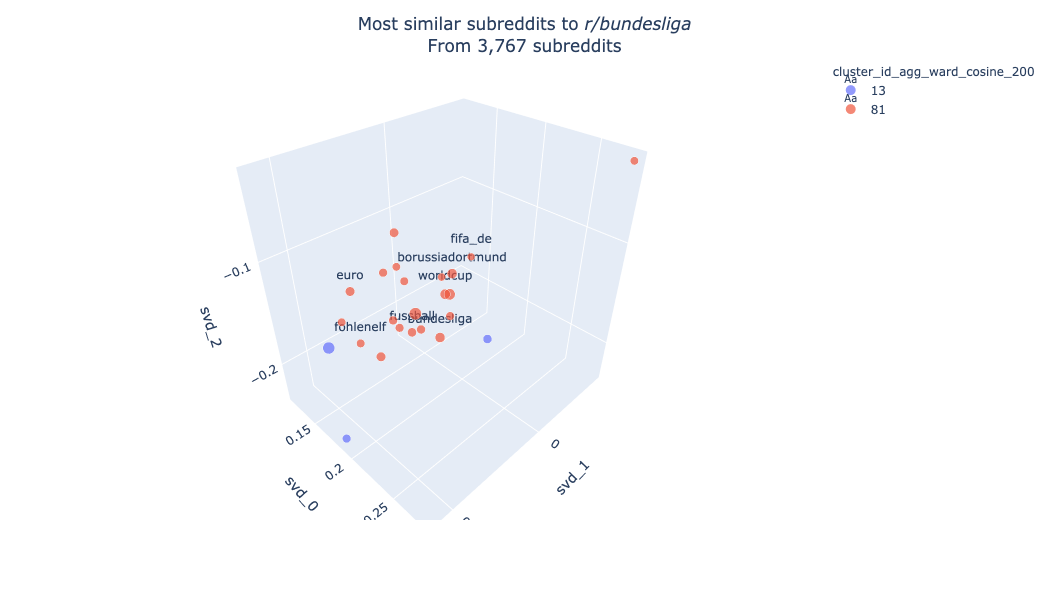

,cosine distance,subreddit name a,subreddit name b,rating b,topic b,primary post language b,primary post language percent b,post median word count b,rating a,topic a,primary post language a,primary post language percent a,post median word count a
0,0.8693,ameisenstrassenwetten,mauerstrassenwetten,r,Internet Culture and Memes,German,87.96%,9,None,None,German,88.37%,12
1,0.8126,ameisenstrassenwetten,farialimabets,None,None,Portuguese,70.94%,9,None,None,German,88.37%,12
2,0.7751,ameisenstrassenwetten,dalalstreetbets,not_shown_in_theaters,"Business, Economics, and Finance",English,84.47%,12,None,None,German,88.37%,12
3,0.7745,ameisenstrassenwetten,wallstreetbets,r,None,English,90.83%,14,None,None,German,88.37%,12
4,0.7664,ameisenstrassenwetten,aktien,None,None,German,96.74%,38,None,None,German,88.37%,12
5,0.7089,ameisenstrassenwetten,stockstobuytoday,None,None,English,94.52%,16,None,None,German,88.37%,12
6,0.7056,ameisenstrassenwetten,amcstock,None,None,English,88.67%,12,None,None,German,88.37%,12
7,0.7025,ameisenstrassenwetten,stock,None,None,English,83.33%,20,None,None,German,88.37%,12
8,0.6983,ameisenstrassenwetten,etc,None,None,English,96.10%,18,None,None,German,88.37%,12
9,0.6981,ameisenstrassenwetten,ecomi,None,None,English,93.25%,21,None,None,German,88.37%,12



Cluster ID: 22
  28 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,22,78.6%
"business, economics, and finance",4,14.3%
over18_nsfw,1,3.6%
internet culture and memes,1,3.6%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post type,primary post type percent,users l28,posts l28,comments l28,post median word count,primary post language in use multilingual,manual topic and rating,rating version,over 18
wallstreetbets,r,None,wallstreetbets,English,90.83%,image,35.67%,"7,636,762","43,615","1,187,212",14,True,uncategorized,v2,f
amcstock,None,None,amcstock,English,88.67%,image,65.42%,"1,864,135","46,778","980,536",12,True,uncategorized,None,f
stocks,not_shown_in_theaters,None,Stocks - Investing and trading for all,English,100.00%,text,99.92%,"1,842,886","5,356","99,648",117,True,uncategorized,v2,f
investing,pg13,None,Lose money with friends!,English,99.50%,text,100.00%,"1,284,784","3,641","55,567",140,True,uncategorized,v1,f
pennystocks,r,None,Welcome to /r/pennystocks,English,98.67%,text,73.17%,"689,835","3,388","41,325",191,True,uncategorized,v1,f
options,pg13,None,/r/Options,English,100.00%,text,92.67%,"593,598","2,453","33,751",94,True,uncategorized,v2,f
finanzen,pg,"Business, Economics, and Finance",Fragen und Antworten zu Finanzen,German,96.00%,text,82.00%,"233,475","1,096","29,755",103,True,"business, economics, and finance",v1,None
dividends,pg13,None,Dividend Investing,English,99.69%,text,92.86%,"164,369",746,"15,064",75,True,uncategorized,v2,f
mauerstrassenwetten,r,Internet Culture and Memes,mauerstrassenwetten,German,87.96%,image,53.98%,"133,744",653,"56,007",9,True,internet culture and memes,None,None
aktien,None,None,"Aktien, Handel und Investmentstrategien",German,96.74%,text,84.57%,"22,071",306,"2,023",38,True,uncategorized,None,f


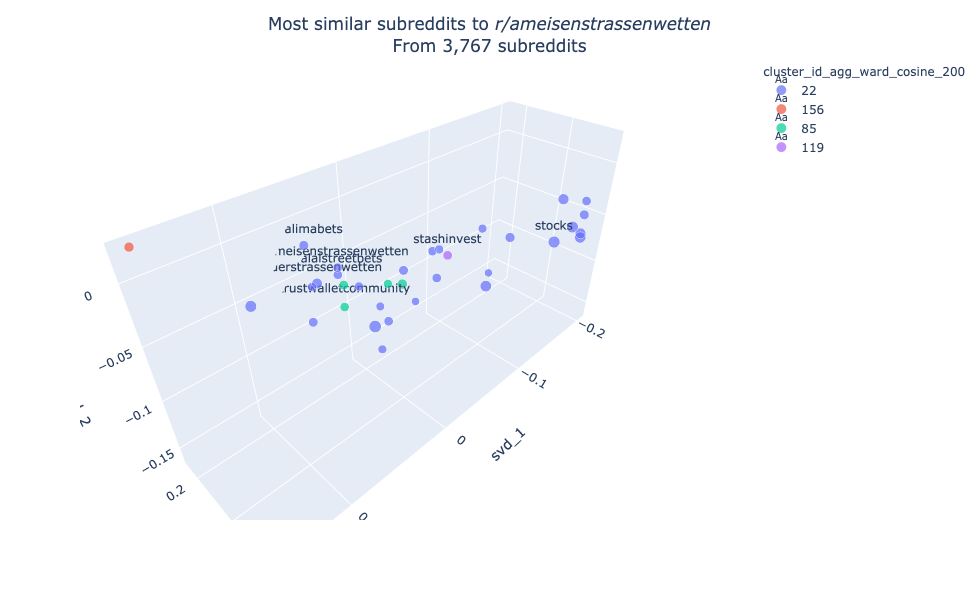

CPU times: user 1.83 s, sys: 11.7 ms, total: 1.84 s
Wall time: 1.81 s


In [115]:
%%time

display_plot_png = False
display_plot_js = True

for sub_ in ['bundesliga', 'ameisenstrassenwetten']:
# for sub_ in ['american_football', 'nfl', 'raiders',]:  # 'baseball',
# for sub_ in ['american_football', 'futbol', 'bundesliga', 'finanzen', 'finance']:
# for sub_ in ['hamburg', 'germanrap', 'de_iama', 'bundesliga', 'finanzen', 'vegande', 'ich_iel']:
    # closest subs
    df_closest_subs_ = (
        df_sub_d_pair[df_sub_d_pair['subreddit_name_a'] == sub_]
        .sort_values(by='cosine_distance', ascending=False)
        .drop(['subreddit_id_a', 'subreddit_id_b'], axis=1)
        .reset_index(drop=True)
        .head(20)
    )
    l_closest_subs = [sub_] + list(df_closest_subs_['subreddit_name_b'])

    display(
        style_df_numeric(
            df_closest_subs_,
            rename_cols_for_display=True,
            l_bar_simple=['cosine_distance', 'primary_post_language_percent_b'],
            float_round=4,
        )  #.hide_index()
    )

    # cluster assigned by ML
    sub_id = df_subs_meta_plot.loc[df_subs_meta_plot['subreddit_name'] == sub_,
                                   col_clustering].values[0]
    l_subs_in_cluster = list(
        df_subs_meta_plot[df_subs_meta_plot[col_clustering] == sub_id]
        ['subreddit_name']
    )

    display_items_for_cluster_id(
        df_subs_meta_plot=df_subs_meta_plot,
        id_=sub_id,
    )

    set_subs_all_similar = set(l_closest_subs) | set(l_subs_in_cluster)
    # print(set_subs_all_similar)
    
    
    if (display_plot_png | display_plot_js):
        # display overlap between closest subs and subs that are part of the selected cluster
        # options:
        #  - Could display in SVD or t-sne space as dots
        #  - Could display as a table with flags for cluster IDs & distances
        #. - or venn diagram?
        # works with recent plotly (custom data)
        df_plot_ = (
            df_subs_meta_plot[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
        )
        
        # Select subs to display: self + 3 closest & 3 furthest away
        # assumes closest subs has already been sorted
        l_names_to_show = (
            [sub_] + 
            list(df_closest_subs_['subreddit_name_b'].head(3)) + 
            list(df_closest_subs_['subreddit_name_b'].tail(3))
        )
        df_plot_['subreddit_name_sparse'] = np.where(
            df_plot_['subreddit_name'].isin(l_names_to_show),
            df_plot_['subreddit_name'],
            ''
        )
        

        l_custom_data_subs = [
          'subreddit_name', 
          col_manual_labels,
          # 'text_1',
          # 'text_2',
        ]
        sub_hover_data = "<br>".join([
            "subreddit name: %{customdata[0]}",
            "subreddit manual label: %{customdata[1]}",
            # "post text: %{customdata[2]}",
            # "  %{customdata[3]}"
        ])

        fig = px.scatter_3d(
            df_plot_,
            y='svd_0', x='svd_1', z='svd_2',
            color=col_clustering,  # color=col_manual_labels,
            custom_data=l_custom_data_subs,
            size=100 * np.log2(1 + df_plot_['users_l28']),
            text='subreddit_name_sparse',
            # hoverinfo='text',
        )

        fig.update_traces(hovertemplate=sub_hover_data)
        fig.update_layout(
            title_text=(
                f"Most similar subreddits to <i>r/{sub_}</i>"
                f"<br>From {len(df_subs_meta_plot):,.0f} subreddits"
                # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
                # f"<br>Using posts from 04-01-2021 to 05-08-2021"
            ),
            title_x=0.5,
            width=800,
            height=600,
        #     uniformtext_minsize=8, uniformtext_mode='hide'
        )
        if display_plot_png:
            fig.show(renderer='png')
        if display_plot_js:
            fig.show()

# Loop through clusters that have at least one German Subreddit

In reality, these will be the primary use case to find recommendations.
Subs that are:
- Germany geo-relevant
- From German ambassador program
- Primarily in German

### Get subreddit IDs for Germany-relevant subs

Need to load the data from a separate dataframe that has the geo-relevant ranks!

In [58]:
df_sub_meta.shape

(3767, 74)

In [61]:
[c for c in df_sub_meta.columns if 'count' in c]

['subreddit_clean_description_word_count',
 'subreddit_name_title_and_clean_descriptions_word_count',
 'post_median_word_count']

In [62]:
[c for c in df_sub_meta.columns if 'lang' in c]

['subreddit_language',
 'Other language_posts_percent',
 'primary_post_language',
 'primary_post_language_percent',
 'primary_post_language_in_use_multilingual']

In [78]:
# df_sub_meta.iloc[:5, :25]

In [71]:
# find subs that are germany re
# df_subs_meta_plot.head()